In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from matplotlib import pyplot as plt

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

# MIXED_PRECISION = True
# if MIXED_PRECISION:
#     try: 
#         tpu
#         policy = tf.keras.mixed_precision.Policy('mixed_bfloat16')
#     else: #
#         policy = tf.keras.mixed_precision.Policy('mixed_float16')
#         tf.config.optimizer.set_jit(True) # XLA compilation
#     tf.keras.mixed_precision.set_global_policy(policy)
#     print('Mixed precision enabled')


In [ ]:
training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
training_dataset = get_training_dataset(training_images_file, training_labels_file, 128)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# Basic CNN

#GPU vs TPU


In [ ]:
x_train, y_train, x_test, y_test = get_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:

import keras

In [ ]:
# import datetime
# import tensorflow as tf
# class etimer(keras.callbacks.Callback):
#     def __init__ (self): # initialization of the callback
#         super(etimer, self).__init__()
#     def on_epoch_begin(self,epoch, logs=None):
#         self.now= time.time()
#     def on_epoch_end(self,epoch, logs=None): 
#         later=time.time()
#         duration=later-self.now 
#         print('\nfor epoch ', epoch +1, ' the duration was ', duration, ' seconds')

# timing = etimer()


Epoch 1/10
469/469 [==============================] - 13s 5ms/step - loss: 1.5142 - accuracy: 0.7306
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.3211 - accuracy: 0.9035
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2167 - accuracy: 0.9341
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1742 - accuracy: 0.9474
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1492 - accuracy: 0.9549
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1345 - accuracy: 0.9599
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1230 - accuracy: 0.9621
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1087 - accuracy: 0.9669
Epoch 9/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1036 - accuracy: 0.9683
Epoch 10/10
1/1 [==============================] - 1s 626ms/step - loss: 0.0439 - accuracy: 0.9853


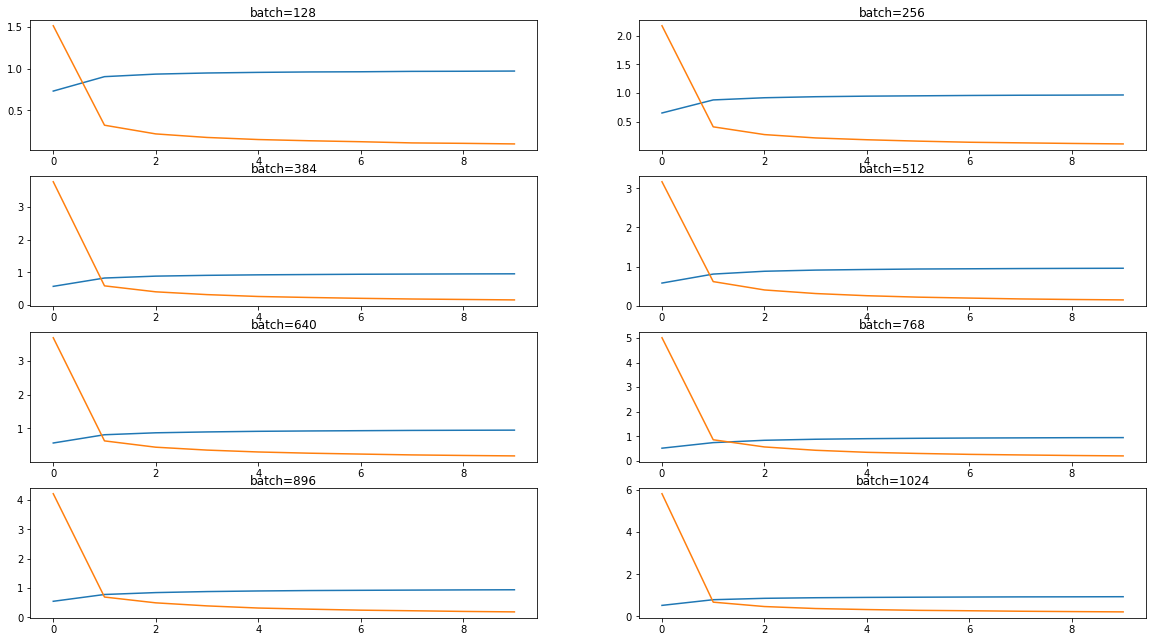

In [ ]:
import pandas as pd
batch_size = [16*8*x for x in range(1, 9)]
seconds = []
accuracy = []
val_acc = []
loss = []
val_loss = []
plt.subplots(4, 2, figsize=(20, 11))
plot_batches(batch_size)
for n in range(len(batch_size)):
    with strategy.scope():
        model = create_model()
        starttime = time.time()
        history = model.fit(x_train,
            y_train,
            batch_size=batch_size[n],
            epochs=10,
            )
        seconds.append((time.time() - starttime ))
    final_stats = model.evaluate(x_test, y_test, steps=1)
    plot_no = 420+(n+1)
    plt.subplot(plot_no)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['loss'], label='train')
    plt.title(f'batch={batch_size[n]}', pad=-40)
    accuracy.append(history.history['accuracy'][-1])
    loss.append(history.history['loss'][-1])
    val_acc.append(final_stats[1])
    val_loss.append(final_stats[0])

In [ ]:
strategy.num_replicas_in_sync

8

In [ ]:

df = pd.DataFrame(data={'accuracy': accuracy, 'loss': loss, 'val_loss': val_loss, 'val_acc': val_acc, 'seconds': seconds}, index=batch_size)
df

,accuracy,loss,val_loss,val_acc,seconds
128,0.983400,0.052600,0.028206,0.9913,84.098077
256,0.981150,0.060010,0.032532,0.9893,45.032599
384,0.980783,0.059718,0.033043,0.9906,32.888604
512,0.978850,0.071494,0.032898,0.9891,27.611130
640,0.977200,0.073718,0.037300,0.9876,25.504067
768,0.975933,0.078654,0.038223,0.9877,22.063627
896,0.975383,0.078621,0.037384,0.9880,19.729057
1024,0.973700,0.085918,0.041534,0.9868,18.240821


In [ ]:
df.to_csv('TPU_basic.csv', index=False)

# Benchmarks 

Note that TPU setup takes some time when compiling the model and distributing the data in the clusters, so the first epoch will take alonger time. I only reported the time for the later epochs. I calculated the average time accross different epochs.

### Epoch Time ($s$)

$$\left[\begin{array}{c|c|c}  
 \textbf{Batch Size} & \textbf{GPU} & \textbf{TPU} \\
 256 & 6s & 6s\\  
 512 & 5s & 3s\\
 1024 & 4s & 2s\\
\end{array}\right]$$

### Step Time ($\mu s$)

$$\left[\begin{array}{c|c|c}  
 \textbf{Batch Size} & \textbf{GPU} & \textbf{TPU} \\
 256 & 94 \mu s & 97 \mu s\\  
 512 & 82 \mu  s& 58 \mu s \\
 1024 & 79 \mu s & 37 \mu s\\
\end{array}\right]$$

# References



*   https://qiita.com/koshian2/items/25a6341c035e8a260a01
*   https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a
*   https://blog.riseml.com/benchmarking-googles-new-tpuv2-121c03b71384
*   https://cloudplatform.googleblog.com/2018/02/Cloud-TPU-machine-learning-accelerators-now-available-in-beta.html

